# Basic Family Detection

This example demonstrates how to use `tobac` for family detection on synthetic data containing a large blob with multiple smaller, more intense blobs nested within it.

## Overview

In this notebook, we will:
1. Create synthetic data, with one large, less intense blob, and several smaller, more intense blobs within it.
3. Use tobac's feature detection to identify the intense blobs
4. Use tobac's family detection to link these features as one family.


## Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.ndimage import gaussian_filter
import tobac

# Set random seed for reproducibility
np.random.seed(42)

## Create Synthetic Data

We'll create a 2D field with:
- A large, diffuse background blob with moderate intensity
- 5 smaller, intense blobs positioned within the larger blob

This simulates a scenario where you might have a broad atmospheric feature (like a mesoscale convective system) with embedded intense convective cells.

In [2]:
# Define grid dimensions
nx, ny = 200, 200
x = np.arange(nx)
y = np.arange(ny)
X, Y = np.meshgrid(x, y)

# Initialize the field
field = np.zeros((ny, nx))

# Create a large background blob centered in the domain
center_x, center_y = 100, 100
sigma_large = 40  # Large blob spread
amplitude_large = 60  # Moderate intensity

# Add the large Gaussian blob
large_blob = amplitude_large * np.exp(
    -((X - center_x)**2 + (Y - center_y)**2) / (2 * sigma_large**2)
)
field += large_blob

# Define positions for 5 smaller, intense blobs within the large blob
# These are positioned in a pattern within the larger blob
small_blob_positions = [
    (80, 80),   # Upper left
    (120, 80),  # Upper right
    (100, 100), # Center
    (80, 120),  # Lower left
    (120, 120)  # Lower right
]

sigma_small = 8  # Small blob spread
amplitude_small = 50  # High intensity (higher than background)

# Add the 5 intense blobs
for pos_x, pos_y in small_blob_positions:
    small_blob = amplitude_small * np.exp(
        -((X - pos_x)**2 + (Y - pos_y)**2) / (2 * sigma_small**2)
    )
    field += small_blob

# Add some noise to make it more realistic
noise = np.random.normal(0, 1, field.shape)
field += noise

# Smooth the field slightly to reduce noise
field = gaussian_filter(field, sigma=0.5)

print(f"Field shape: {field.shape}")
print(f"Field range: {field.min():.2f} to {field.max():.2f}")

Field shape: (200, 200)
Field range: -1.83 to 110.11


## Prepare Data for tobac

tobac works with xarray DataArrays that have specific coordinate and dimension names. We'll create an xarray DataArray with appropriate metadata.

In [3]:
# Create coordinate arrays
# For this example, we'll use simple grid coordinates
x = np.arange(nx)
y = np.arange(ny)
time = np.array(['2026-01-01T00:00:00'], dtype='datetime64[ns]')  # Single time step

# Create xarray DataArray
data = xr.DataArray(
    field[np.newaxis, :, :],  # Add time dimension
    coords={
        'time': time,
        'x': x,
        'y': y
    },
    dims=['time', 'y', 'x'],
    name='intensity'
)
data

<xarray.DataArray 'intensity' (time: 1, y: 200, x: 200)> Size: 320kB
array([[[ 0.54064717,  0.19960743,  0.82789391, ...,  0.26231846,
          0.09810755, -0.66419651],
        [ 0.31031947,  0.53221927,  1.00906837, ...,  0.74671614,
          0.23523976,  0.91479192],
        [-0.93599967, -0.36009621,  0.29189713, ..., -0.35778644,
         -0.14666944,  0.48745001],
        ...,
        [ 0.12690153,  0.42790158, -0.35233134, ...,  0.57253101,
          0.45695974, -0.20042559],
        [-0.10049394,  0.50000217, -0.71292123, ...,  1.04282455,
          1.45482585, -0.07086827],
        [-0.72549437,  0.389674  , -0.91807389, ...,  0.78870583,
          0.97036958,  0.465329  ]]], shape=(1, 200, 200))
Coordinates:
  * time     (time) datetime64[ns] 8B 2026-01-01
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199

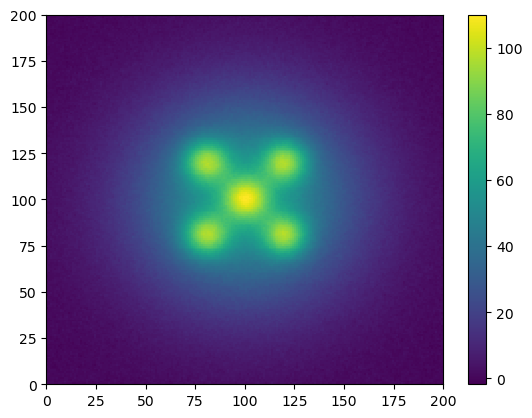

In [4]:
plt.pcolormesh(data[0])
plt.colorbar()

## Configure tobac Feature Detection

We need to set parameters for feature detection:
- `threshold`: Minimum intensity for feature detection
- `target`: Set to "maximum" as we're dealing with a field that increases as it gets more intense
- `position_threshold`: Sets the algorithm for choosing the feature position from the 2D/3D field
- `sigma_threshold`: Sets the smoothing amount

The threshold should be set high enough to detect only the 5 intense blobs, not the background.

In [5]:
# Set parameters for feature detection
parameters = {
    'threshold': [30,80],
    'target': 'maximum',
    'position_threshold': 'weighted_diff',  # Use weighted difference for position
    'sigma_threshold': 1,  # Smoothing parameter
    'n_erosion_threshold': 0,  # No erosion
    'n_min_threshold': 1,  # Minimum number of pixels per feature
}

## Run tobac Feature Detection

Now we'll run tobac's feature detection algorithm to identify the 5 intense blobs.

In [6]:
# Run feature detection
features = tobac.feature_detection_multithreshold(
    data,
    dxy=1,  # Grid spacing (1 unit in both directions)
    **parameters
)
features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,x,y
0,0,3,81.212075,81.216162,174,80,1,2026-01-01,2026-01-01 00:00:00,81.216162,81.212075
1,0,4,81.219630,118.810947,175,80,2,2026-01-01,2026-01-01 00:00:00,118.810947,81.219630
2,0,5,100.021091,99.990637,397,80,3,2026-01-01,2026-01-01 00:00:00,99.990637,100.021091
3,0,6,118.814906,81.229949,172,80,4,2026-01-01,2026-01-01 00:00:00,81.229949,118.814906
4,0,7,118.763451,118.781232,169,80,5,2026-01-01,2026-01-01 00:00:00,118.781232,118.763451


## Visualize Results

Finally, we'll create a visualization showing:
1. The original field with both the large blob and the 5 intense blobs
2. Detected feature locations overlaid as scatter points

This allows us to verify that tobac correctly identified the 5 intense blobs.

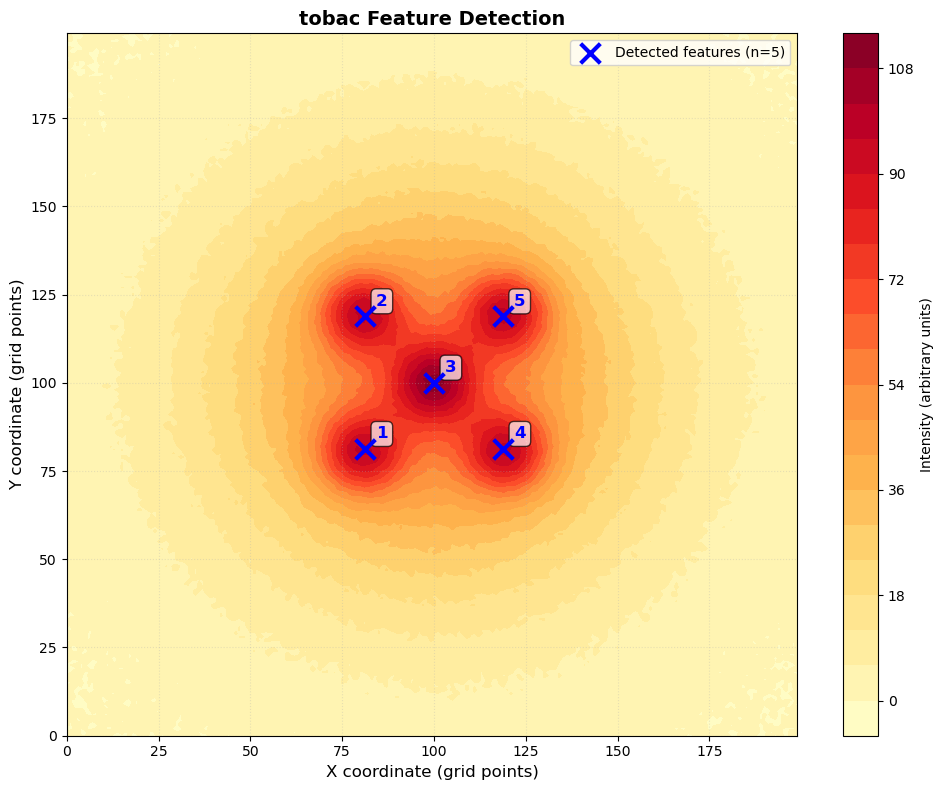

In [7]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the field as a filled contour
im = ax.contourf(X, Y, field, levels=20, cmap='YlOrRd')
cbar = plt.colorbar(im, ax=ax, label='Intensity (arbitrary units)')

# Overlay the detected features as scatter points
if len(features) > 0:
    ax.scatter(
        features['hdim_1'],
        features['hdim_2'],
        c='blue',
        s=200,
        marker='x',
        linewidths=3,
        label=f'Detected features (n={len(features)})',
        zorder=5
    )
    
    # Add feature numbers as labels
    for idx, row in features.iterrows():
        ax.text(
            row['hdim_1'] + 3,
            row['hdim_2'] + 3,
            str(row['feature']),
            color='blue',
            fontsize=12,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )

# Labels and title
ax.set_xlabel('X coordinate (grid points)', fontsize=12)
ax.set_ylabel('Y coordinate (grid points)', fontsize=12)
ax.set_title('tobac Feature Detection', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

## Family Detection from Data

In [8]:
family_df, family_stats_df, family_grid = tobac.merge_split.families.identify_feature_families_from_data(features, data, threshold=40, return_grid=True)

We can now see that all of the features are assigned the same family in the `feature_family_id` column.

In [9]:
family_df

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,x,y,feature_family_id
0,0,3,81.212075,81.216162,174,80,1,2026-01-01,2026-01-01 00:00:00,81.216162,81.212075,1
1,0,4,81.219630,118.810947,175,80,2,2026-01-01,2026-01-01 00:00:00,118.810947,81.219630,1
2,0,5,100.021091,99.990637,397,80,3,2026-01-01,2026-01-01 00:00:00,99.990637,100.021091,1
3,0,6,118.814906,81.229949,172,80,4,2026-01-01,2026-01-01 00:00:00,81.229949,118.814906,1
4,0,7,118.763451,118.781232,169,80,5,2026-01-01,2026-01-01 00:00:00,118.781232,118.763451,1


In addition to modifying the feature DataFrame, we also get a new *statistics* dataframe, which is ordered by the list of families, rather than by the features.

In [10]:
family_stats_df

,num_pixels,hdim_1_center,hdim_2_center,time
feature_family_id,,,,
1,5147.0,100.009909,100.058092,2026-01-01


And, optionally, we get a grid output.

In [11]:
family_grid

<xarray.DataArray 'family_grid' (time: 1, y: 200, x: 200)> Size: 320kB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], shape=(1, 200, 200))
Coordinates:
  * time     (time) datetime64[ns] 8B 2026-01-01
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 192 193 194 195 196 197 198 199

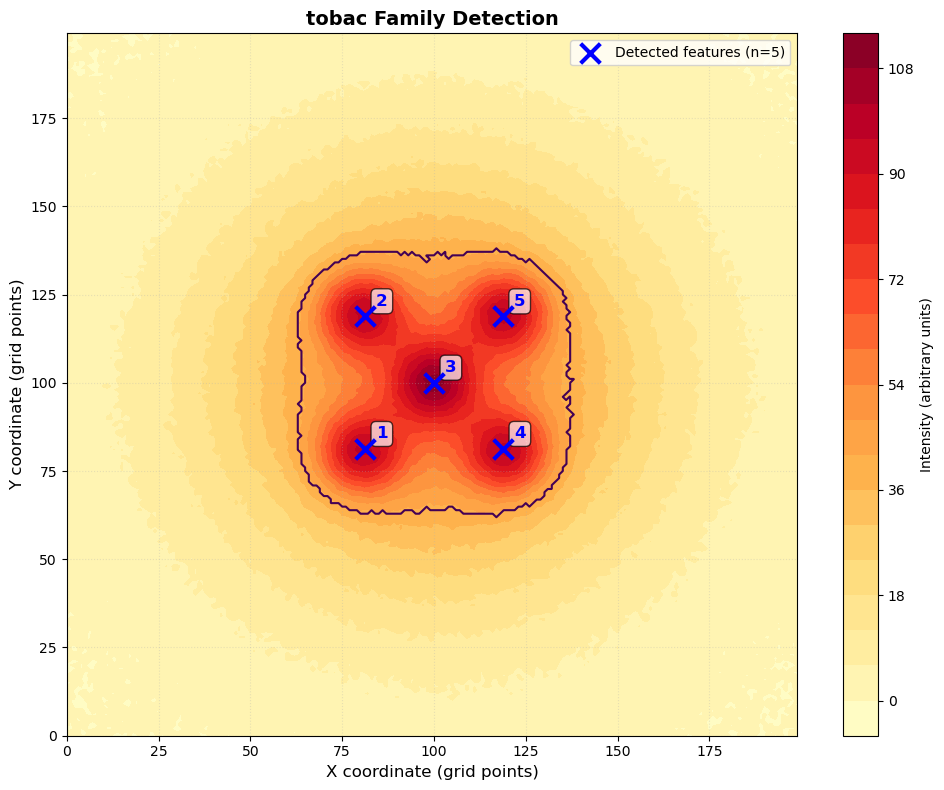

In [12]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the field as a filled contour
im = ax.contourf(X, Y, field, levels=20, cmap='YlOrRd')
cbar = plt.colorbar(im, ax=ax, label='Intensity (arbitrary units)')

# Overlay the detected features as scatter points
if len(features) > 0:
    ax.scatter(
        features['hdim_1'],
        features['hdim_2'],
        c='blue',
        s=200,
        marker='x',
        linewidths=3,
        label=f'Detected features (n={len(features)})',
        zorder=5
    )

    # Add feature numbers as labels
    for idx, row in features.iterrows():
        ax.text(
            row['hdim_1'] + 3,
            row['hdim_2'] + 3,
            str(row['feature']),
            color='blue',
            fontsize=12,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )

ax.contour(X, Y, family_grid[0].values, levels=[0.9])

# Labels and title
ax.set_xlabel('X coordinate (grid points)', fontsize=12)
ax.set_ylabel('Y coordinate (grid points)', fontsize=12)
ax.set_title('tobac Family Detection', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, linestyle=':')

plt.tight_layout()
plt.show()

Unlike feature detection, as you can see, family output is *not* smoothed.